In [1]:
import sys
dir_repo = '../../'
sys.path.append(dir_repo)

from emu_Nx2pt.utils import get_config_from_yaml
from emu_Nx2pt.mlp_emulator import MLP_Emulator

! rm -rf /home/hhg/Research/emu_Nx2pt/repo/emulator_Nx2pt/experiments/mlp_test/

In [3]:
config = get_config_from_yaml(dir_repo+'configs/mlp_test.yaml')
config.output_size = [25]*97
emu = MLP_Emulator(config=config)


------ Parameters ------

exp_name : mlp_test
cuda : True
ngpu : 1
gpu_device : 0
workers : 16
dir_output : /home/hhg/Research/emu_Nx2pt/repo/emulator_Nx2pt/experiments
dir_dataT : {'train': '/home/hhg/Research/emu_Nx2pt/data/dataT_1M/', 'valid': '/home/hhg/Research/emu_Nx2pt/data/dataT_0.1M/'}
file_pco : {'train': '/home/hhg/Research/emu_Nx2pt/data/pco_1M.pkl', 'valid': '/home/hhg/Research/emu_Nx2pt/data/pco_0.1M.pkl'}
file_model_state : None
startID : 0
endID : 2425
model_type : ParallelMicroNets
output_size : [25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25]
hidden_size : 32
encode_size : 32
Nblocks : 1
is_batchNorm : False
scale_factor : 1
num_epoc

In [4]:
emu.train()


------ Create experiment directory ------

Training information will be stored at :
 	 /home/hhg/Research/emu_Nx2pt/repo/emulator_Nx2pt/experiments/mlp_test
--- Epoch 1/10 ---
	train avg_chi2: 25772.68	valid avg_chi2: 4849.53	Time: 12m 56s
--- Epoch 2/10 ---


KeyboardInterrupt: 

## Plots: Training States

In [4]:
import numpy as np
import torch

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rc('font', size=16)

In [5]:
trainInfo = torch.load(emu.file_trainInfo)

In [6]:
trainInfo.keys()

dict_keys(['train_loss', 'valid_loss', 'epoch_train_loss', 'epoch_valid_loss', 'lr', 'best_epochID', 'best_model_wts'])

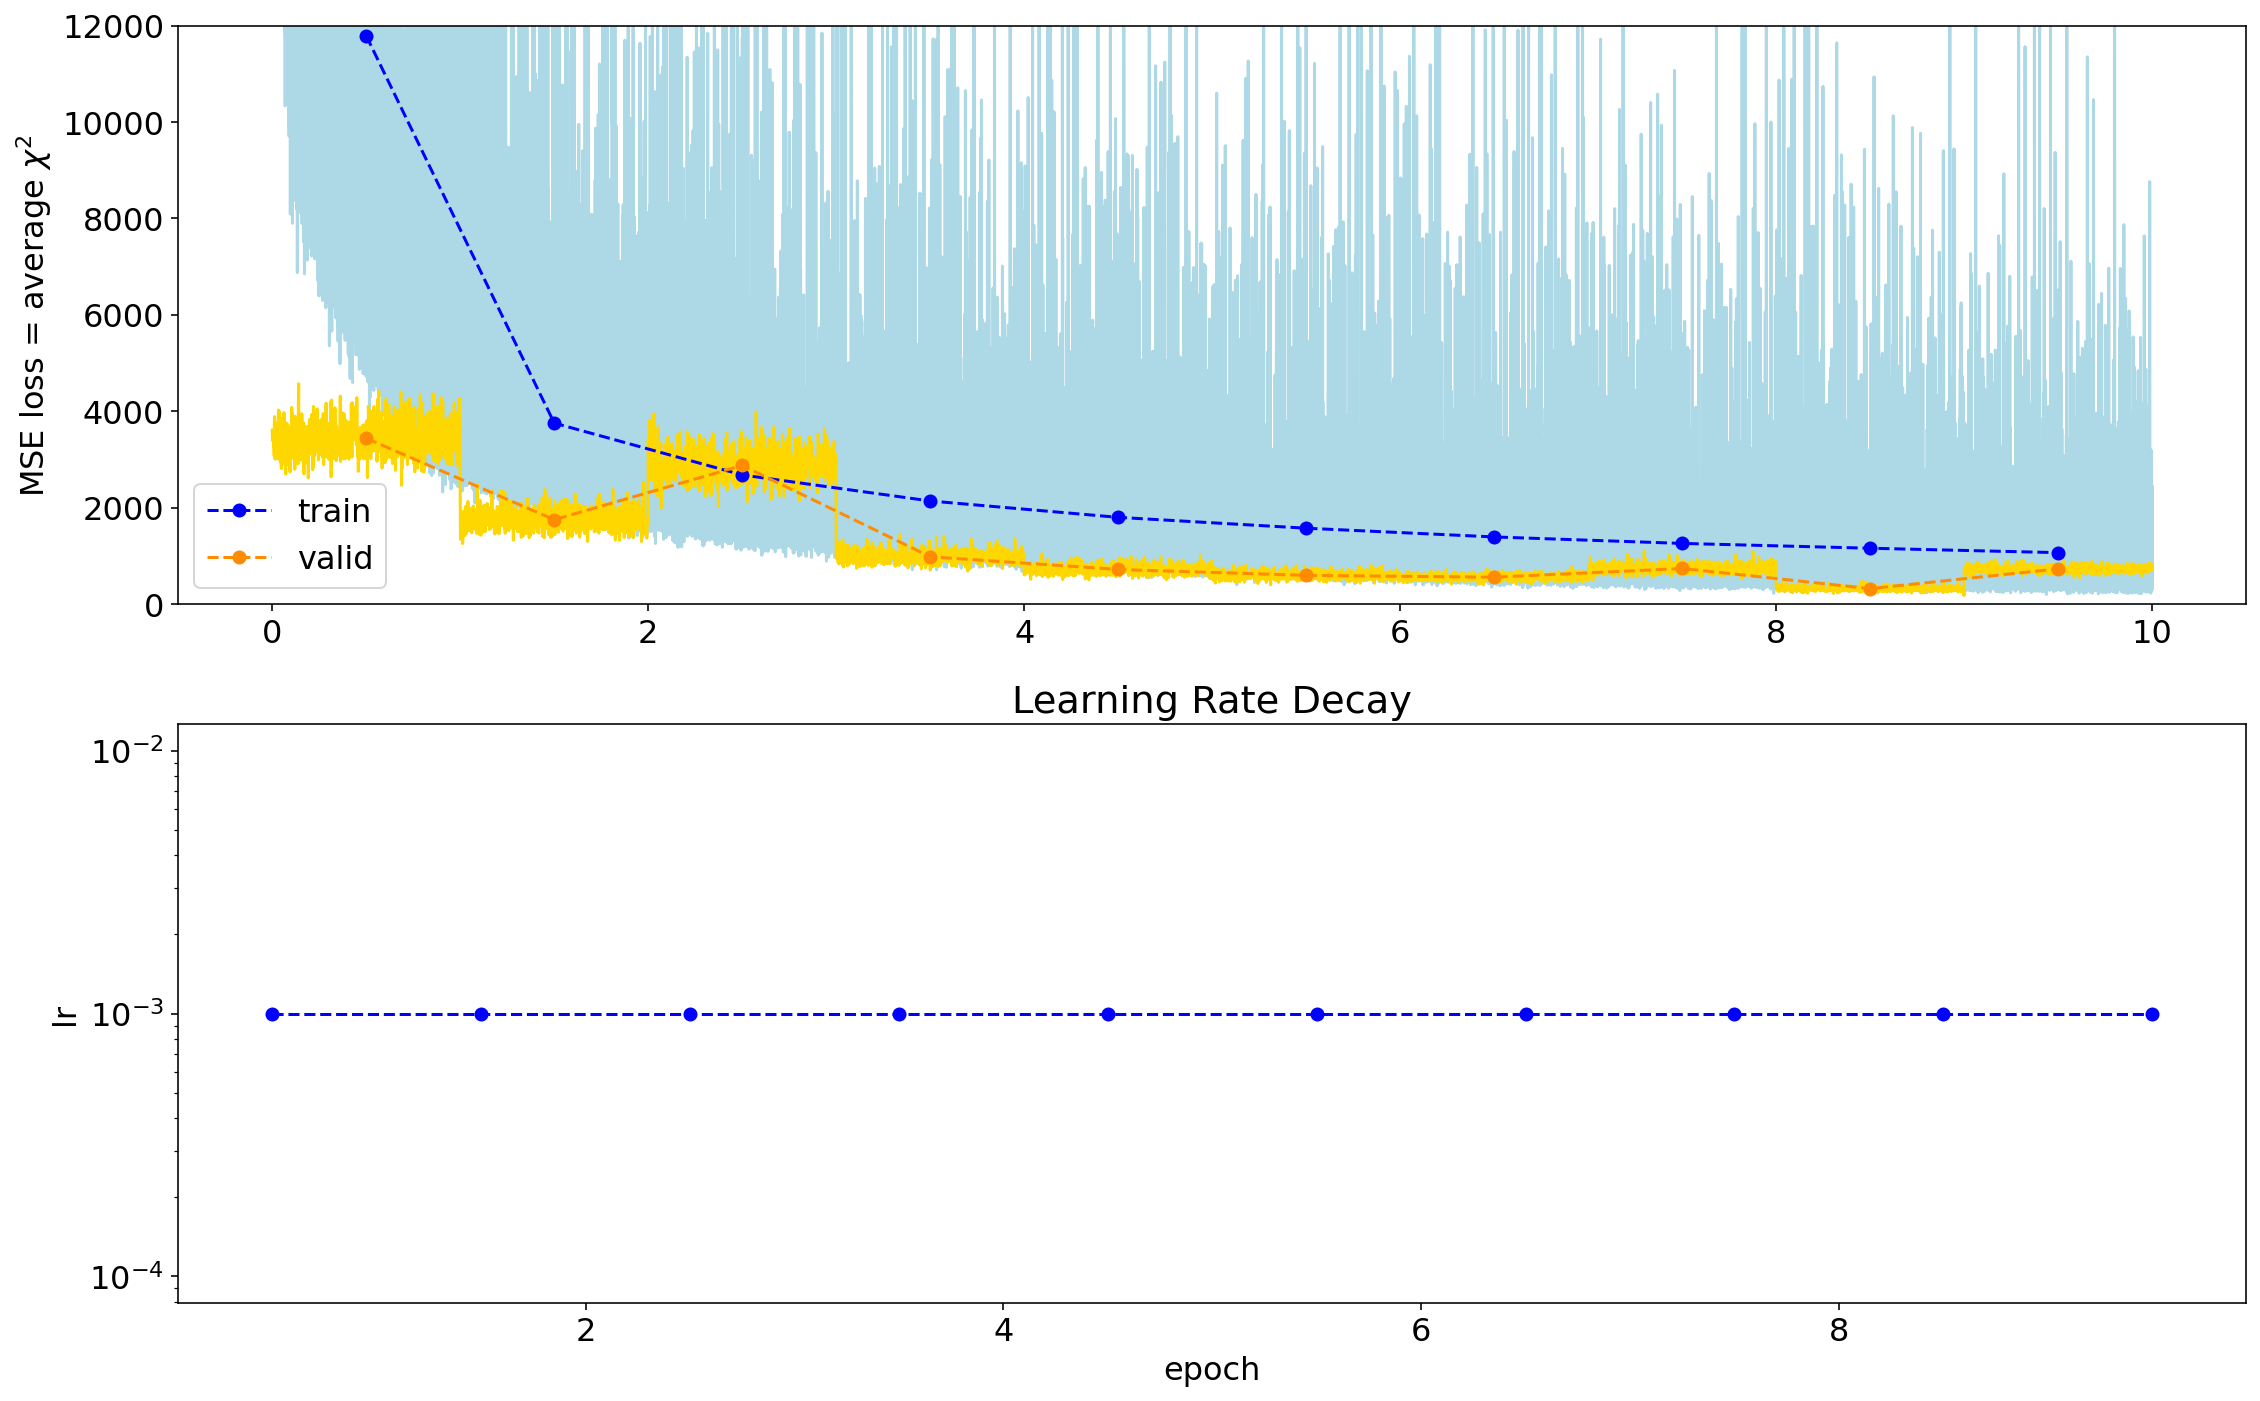

In [7]:
iter_tick = {}
for phase in ['train', 'valid']:
    iter_tick[phase] = np.array(range(len(trainInfo[f'{phase}_loss'])))/len(emu.dataloader[phase])

epoch_tick = np.array(range(len(trainInfo['epoch_train_loss'])))+0.5

# --------------------------

plt.figure(figsize=(16,10))

plt.subplot(211)

n = 1
plt.plot(iter_tick['train'][::n], trainInfo['train_loss'][::n], color='lightblue')
plt.plot(iter_tick['valid'][::n], trainInfo['valid_loss'][::n], color='gold')

plt.plot(epoch_tick, trainInfo['epoch_train_loss'], 'o--', label='train', color='b')
plt.plot(epoch_tick, trainInfo['epoch_valid_loss'], 'o--', label='valid', color='darkorange')

plt.ylabel('MSE loss = average $\chi^2$')

plt.legend()

#plt.xlim([10,20])
plt.ylim([0,12000])


plt.subplot(212)
plt.plot(epoch_tick, trainInfo['lr'], 'o--', label='train', color='b' )
plt.title('Learning Rate Decay')
plt.ylabel('lr')
plt.yscale('log')
plt.xlabel('epoch')


plt.tight_layout()

## Check the Performance of the Best Trained Emulator

In [8]:
import torch
import pandas as pd
import pickle
from emu_Nx2pt.data_kits import dataTDataset
from torch.utils.data import DataLoader

In [9]:
filename_pco = '/home/hhg/Research/emu_Nx2pt/data/pco_0.1M.pkl'
dir_dataT = '/home/hhg/Research/emu_Nx2pt/data/dataT_0.1M/'

with open(filename_pco, 'rb') as handle:
    pco_samples = pickle.load(handle)

test_pco = pd.DataFrame(pco_samples)

test_dataset = dataTDataset(test_pco, dir_dataT, emu.startID, emu.endID)
dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=16)

In [10]:
avg_test_chi2 = emu.test(dataloader)
avg_test_chi2

Test model with the best-trained model at epochID: 8

------ Run test loop ------

  Number of galaxies: 100000 (196 batches)
  Average chi2 of the test set: 316.61


316.608905703125

### Visualize emulated dataV

In [11]:
trainInfo = torch.load(emu.file_trainInfo)
emu.model.load_state_dict(trainInfo['best_model_wts'])

# ---------------------------------------------------------------------------

# stateID = 7
# stateInfo = torch.load(emu.dir_checkpoints + f'/stateInfo_{stateID}.pth')
# emu.model.load_state_dict(stateInfo['model_state_dict'])

<All keys matched successfully>

In [12]:
pcoID, pco, dataT = test_dataset[0]
pco = pco.to(emu.device)

dataV_true = emu.L@dataT.numpy()
dataV_emu  = emu.gen_dataV(pco)

dataT_true = dataT.to('cpu').numpy()
dataT_emu  = emu.gen_dataT(pco)
chi2 = np.sum((dataT_true-dataT_emu)**2)

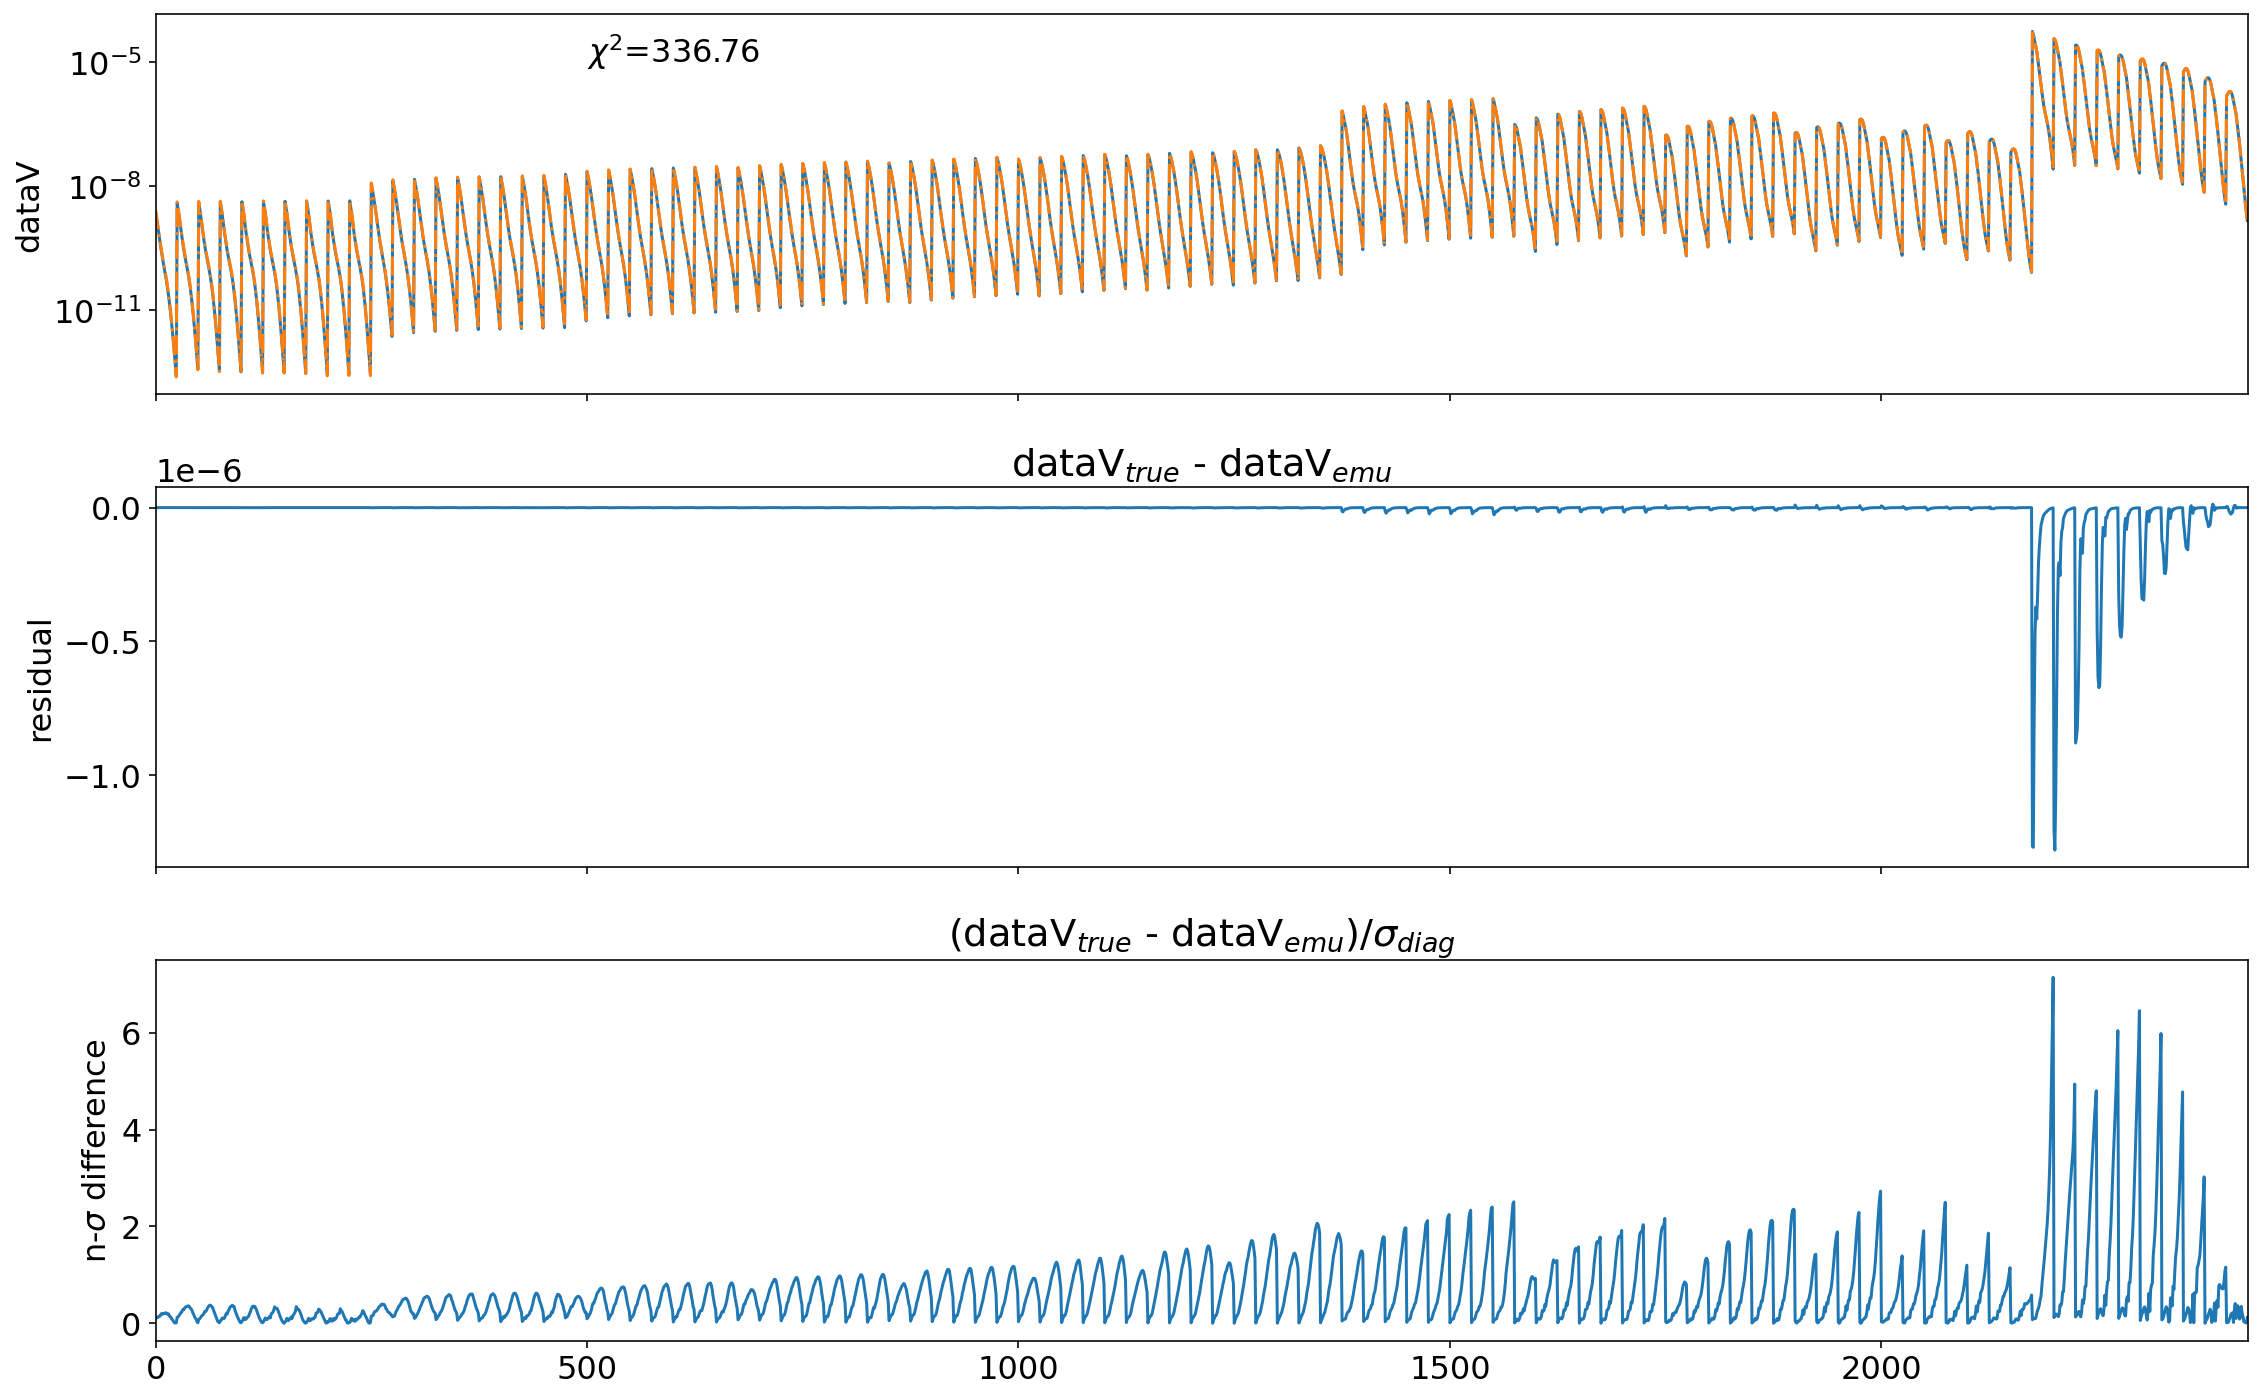

In [13]:
plt.figure(figsize=(16,10))
plt.subplots_adjust(hspace=0.01)

plt.subplot(311)
plt.plot(range(0,emu.endID), dataV_true)
plt.plot(range(0,emu.endID), dataV_emu, ls='-.')
plt.text(500, 1e-5, f"$\chi^2$={chi2:.2f}")

plt.yscale('log')
plt.ylabel('dataV')
plt.xlim([0, emu.endID])
_ = plt.xticks(range(0,emu.endID, 500),[])

plt.subplot(312)
plt.plot(range(0,emu.endID), dataV_true-dataV_emu)
plt.ylabel('residual')
plt.title('dataV$_{true}$ - dataV$_{emu}$')
_ = plt.xticks(range(0,emu.endID, 500),[])
plt.xlim([0, emu.endID])


plt.subplot(313)
dataV_diag_std = np.sqrt(emu.cov_masked.diagonal())[0:emu.endID]
plt.plot(range(0,emu.endID), abs(dataV_true-dataV_emu)/dataV_diag_std )
plt.title('(dataV$_{true}$ - dataV$_{emu}$)/$\sigma_{diag}$')
plt.ylabel('n-$\sigma$ difference')
plt.xlim([0, emu.endID])


plt.tight_layout()